In [1]:
from cycler import cycler
from os import listdir, stat
from os.path import isfile, join

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import numpy as np


In [2]:
%matplotlib inline
# plt.ion()
# sns.set_palette('Set3')
# plt.style.use('Solarize_Light2')
c1 = (cycler('color', ['c', 'r', 'g', 'b', 'y', 'k'])
      * cycler('ls', ['-', '--', ':', '-.']))
c2 = (cycler('ls', ['-', '--', ':', '-.'])
      * cycler('color', ['c', 'k', 'r', 'g', 'b', 'y']))
plt.rc('axes', prop_cycle=c2)


In [3]:
def filterr(df, col, val):
    return df[df[col] == val].reset_index(drop=True)


def filterrnot(df, col, val):
    return df[df[col] != val].reset_index(drop=True)


def filterrnz(df, col):
    return filterrnot(df, col, 0)


In [5]:
ofs_all = pd.read_csv('data/cache-ofs-all.csv')
omap_all = pd.read_csv('data/cache-omap-all.csv')
ssd_ofs = filterr(ofs_all, 'ssd', 1)
hdd_ofs = pd.read_csv('data/hdd-ofs-all.csv')
ssd_omap = filterr(omap_all, 'ssd', 1)
hdd_omap = filterr(omap_all, 'ssd', 0)
sizes = pd.read_csv('data/sizes.csv')
ofs_sizes = filterr(sizes, 'test', 'ofs')
omap_sizes = filterr(sizes, 'test', 'omap')
nocache_omap = pd.read_csv('data/nocache-omap-all.csv')
nocache_ssd_omap = filterr(nocache_omap, 'ssd', 1)
nocache_hdd_omap = filterr(nocache_omap, 'ssd', 0)
nocache_ofs = pd.read_csv('data/nocache-ofs-all.csv')
nocache_ssd_ofs = filterr(nocache_ofs, 'ssd', 1)
nocache_hdd_ofs = filterr(nocache_ofs, 'ssd', 0)
harsh_nocache_omap = pd.read_csv('data/harsh-nocache-omap-all.csv')
harsh_nocache_ssd_omap = filterr(harsh_nocache_omap, 'ssd', 1)
harsh_nocache_hdd_omap = filterr(harsh_nocache_omap, 'ssd', 0)
harsh_nocache_ofs = pd.read_csv('data/harsh-nocache-ofs-all.csv')
harsh_nocache_ssd_ofs = filterr(harsh_nocache_ofs, 'ssd', 1)
harsh_nocache_hdd_ofs = filterr(harsh_nocache_ofs, 'ssd', 0)

ssds = ('SSD', ssd_ofs, ssd_omap)
hdds = ('HDD', hdd_ofs, hdd_omap)
nocache_ssds = ('SSD (No Cache)', nocache_ssd_ofs, nocache_ssd_omap)
nocache_hdds = ('HDD (No Cache)', nocache_hdd_ofs, nocache_hdd_omap)
harsh_nocache_ssds = ('SSD (No Cache + Flush All)',
                      harsh_nocache_ssd_ofs, harsh_nocache_ssd_omap)
harsh_nocache_hdds = ('HDD (No Cache + Flush All)',
                      harsh_nocache_hdd_ofs, harsh_nocache_hdd_omap)
groups = [
    ssds,
    hdds,
    nocache_ssds,
    nocache_hdds,
    harsh_nocache_ssds,
    # harsh_nocache_hdds,
]


In [6]:
for df in [ofs_all, omap_all, nocache_ofs, nocache_omap, harsh_nocache_ofs, harsh_nocache_omap]:
    print(*sorted(list(set(df['bbs']))))


64
64
64
64
64
64


In [7]:
def plot_line(xs, ys, label, color=None, marker=None, ax=None):
    if ax is None:
        ax = plt
    return ax.plot(xs, ys, label=label, color=color, marker=marker)


max_vl = ofs_all['vl'].max()
vl_xticks = [2]
while vl_xticks[-1] < max_vl:
    vl_xticks.append(4*vl_xticks[-1])
vl_xticks = np.asarray(vl_xticks)


def setup_plot(title, xlabel, ylabel, ax=None, xscale='linear', xbase=10, yscale='linear', ybase=10, xticks=vl_xticks):
    if ax is not None:
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        if xscale != 'linear':
            ax.set_xscale(xscale, base=xbase)
        if yscale != 'linear':
            ax.set_yscale(yscale, base=ybase)
        if xticks is not None:
            ax.set_xticks(xticks)
        return

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if xscale != 'linear':
        plt.xscale(xscale, base=xbase)
    if yscale != 'linear':
        plt.yscale(yscale, base=ybase)
    if xticks is not None:
        plt.xticks(xticks)


def grouped_bars(df, group_name, title, yname):
    bars_per_group = len(df.columns) - 1
    x = np.arange(len(df))
    width = 1 / (bars_per_group+1)

    offset_mult = 0
    fig, ax = plt.subplots(layout='constrained')

    for col in filter(lambda x: x != group_name, df.columns):
        offset = width * offset_mult
        rects = ax.bar(x + offset, df[col], width, label=col)
        ax.bar_label(rects, padding=3)
        offset_mult += 1

    ax.set_title(title)
    ax.set_ylabel(yname)
    ax.set_xticks(x + width, df[group_name])
    ax.legend()
    plt.show()


In [23]:

def graph_by(df, col1, col2, xname, yname, sharey=True, omap=None):
    col1_vals = sorted(list(set(df[col1])), reverse=True)
    nplots = len(col1_vals)

    # yscale = 'linear'
    yscale = 'log'
    ybase = 10
    # xscale = 'linear'
    xscale = 'log'
    xbase = 2

    fig, axs = plt.subplots(nplots, sharex=False,
                            sharey=sharey, figsize=(8, (4*nplots)+1))
    plt.subplots_adjust(hspace=.45)
    # all_ymin, all_ymax = None, None

    for cnt, v1 in enumerate(col1_vals):
        ax = axs[cnt]
        ax.grid()
        setup_plot(f'{yname}, {col1.replace("lf", "L")}={v1}', xname, 'time (s)', ax=ax,
                   xscale=xscale, yscale=yscale, xbase=xbase, ybase=ybase)

        dv1 = filterr(df, col1, v1)
        if omap is not None:
            omap_max_n = omap['n'].max()
            omap_ins_time = list(set(filterr(omap, 'n', omap_max_n)[yname]))[0]
            omapx = np.asarray(sorted(list(set(filterrnz(dv1, xname)[xname]))))
            omapy = (omapx * omap_ins_time)
            plot_line(omapx, omapy, 'OMap', ax=ax)

        col2_vals = sorted(list(set(dv1[col2])))
        for v2 in col2_vals:
            dv1v2 = filterr(dv1, col2, v2)
            d = filterrnz(dv1v2, xname)
            d = filterrnz(d, yname)
            d.sort_values([xname], ascending=True, inplace=True)
            x = d[xname]
            y = d[yname]
            plot_line(x, y, f'{col2.replace("lf", "L")}={v2}', ax=ax)

        ymin, ymax = ax.get_ylim()
        # if all_ymin == None:
        #     all_ymin, all_ymax = ymin, ymax
        # else:
        #     all_ymin = min(ymin, all_ymin)
        #     all_ymax = max(ymax, all_ymax)

        if xname == 'vl' and (col1 == 's' or col2 == 's'):
            s = v1 if col1 == 's' else v2
            assert len(set(d['n'])) == 1
            n = list(set(d['n']))[0]
            l = round(np.log2(n))
            p = (l+1) // s
            levels = list(range(l - ((s-1) * p), l+1, p))
            ax.vlines(2 ** np.asarray(levels),
                      ymin=ymin, ymax=ymax,
                      color='purple', linestyle=':', label='level')

    # plt.ylim(all_ymin, all_ymax)
    labels_handles = {
        label: handle
        for ax in axs
        for handle, label in zip(*ax.get_legend_handles_labels())
    }
    # lh_list = sorted(list(labels_handles.items()), key=lambda x: x[0])
    # labels = [x[0] for x in lh_list]
    # handles = [x[1] for x in lh_list]
    labels = labels_handles.keys()
    handles = labels_handles.values()

    leg = fig.legend(
        handles,
        labels,
        loc="upper right",
        bbox_to_anchor=(0.05, 0.5),
        bbox_transform=plt.gcf().transFigure,
    )
    # leg_lines = leg.get_lines()
    # leg_texts = leg.get_texts()
    # plt.setp(leg_lines, linewidth=6)
    plt.show()


SSD


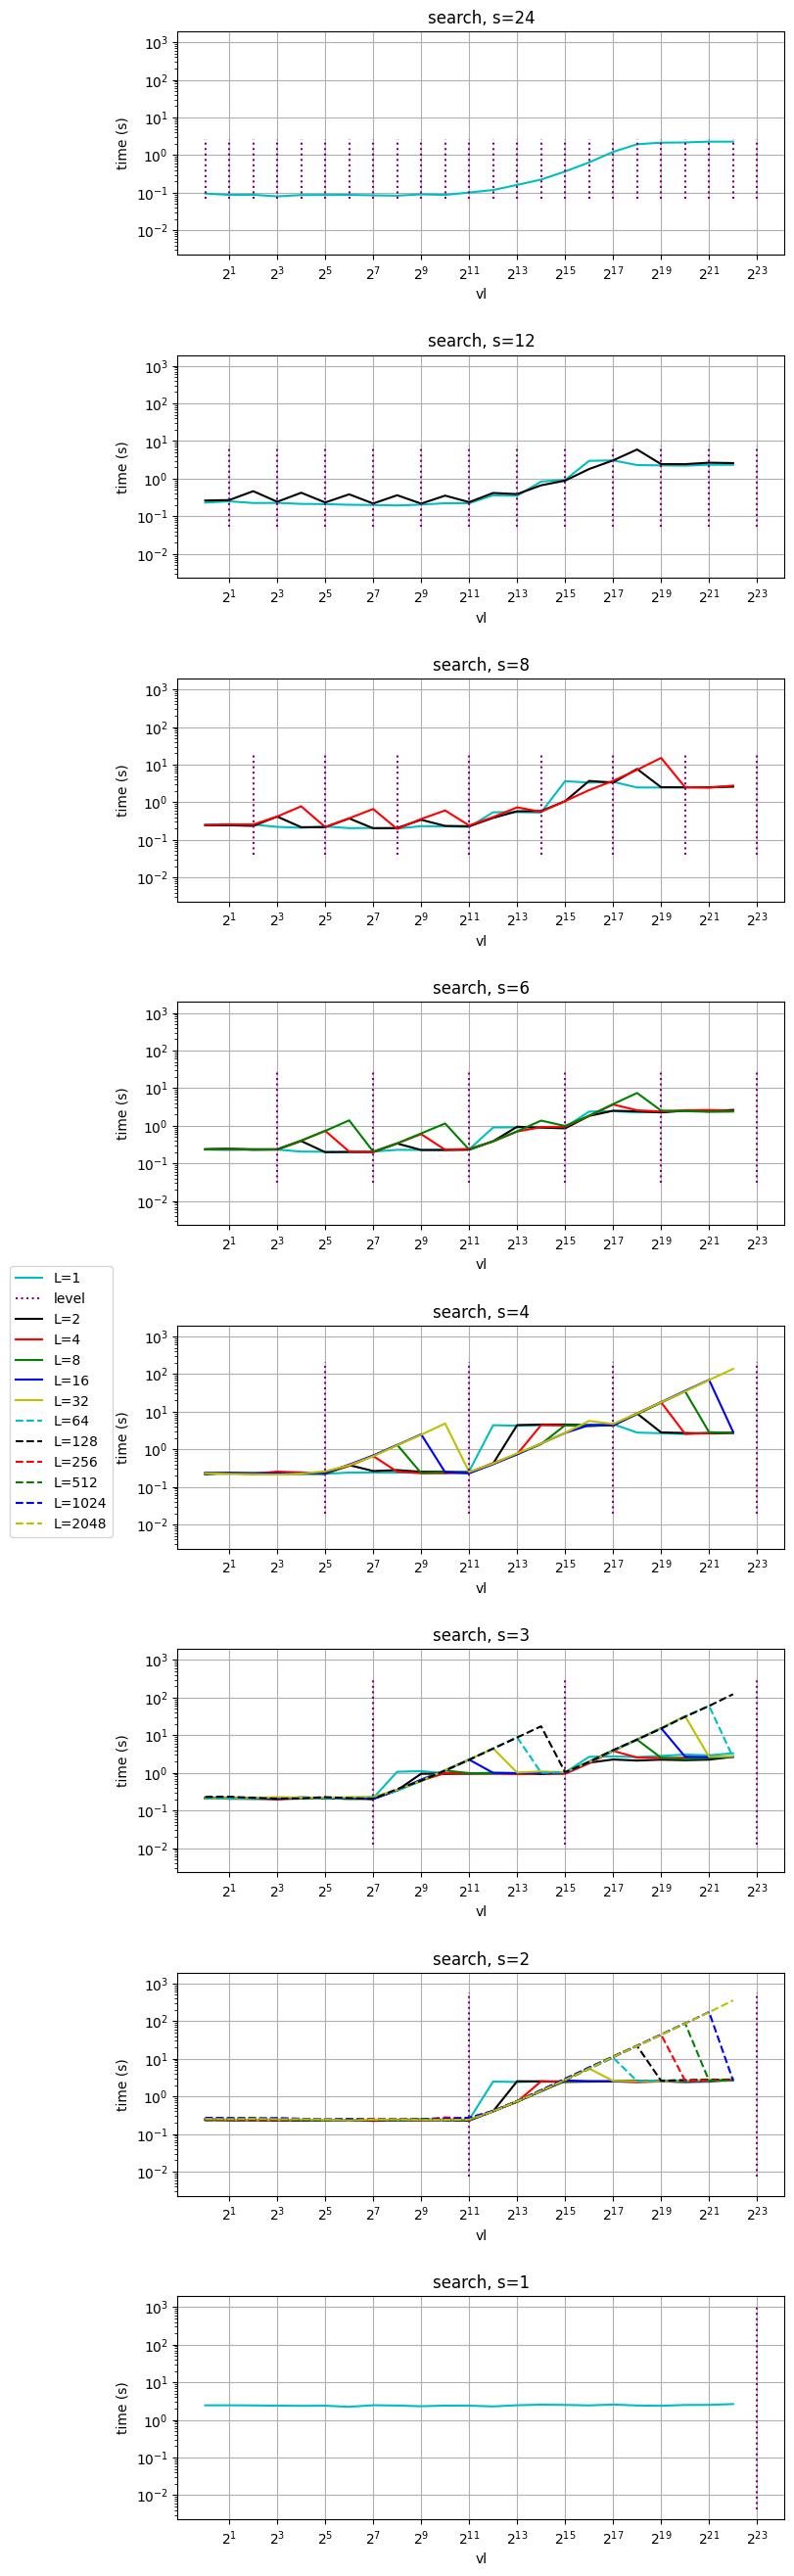

HDD


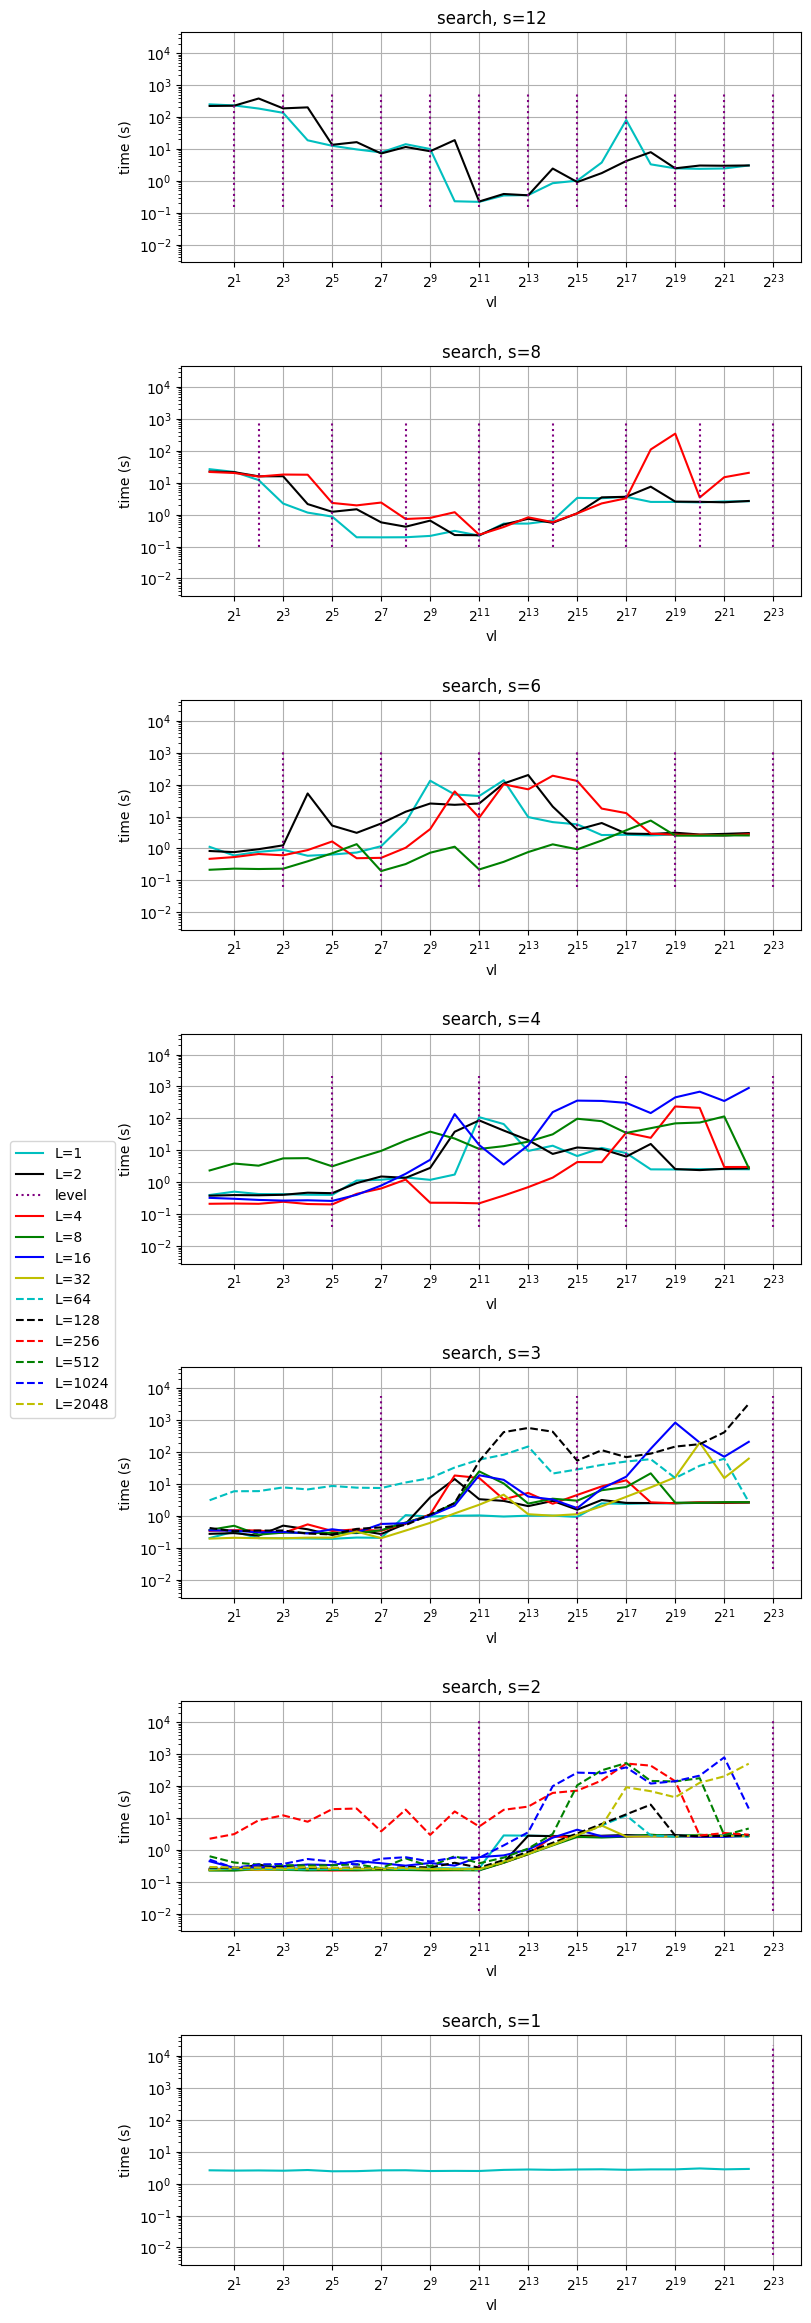

SSD (No Cache)


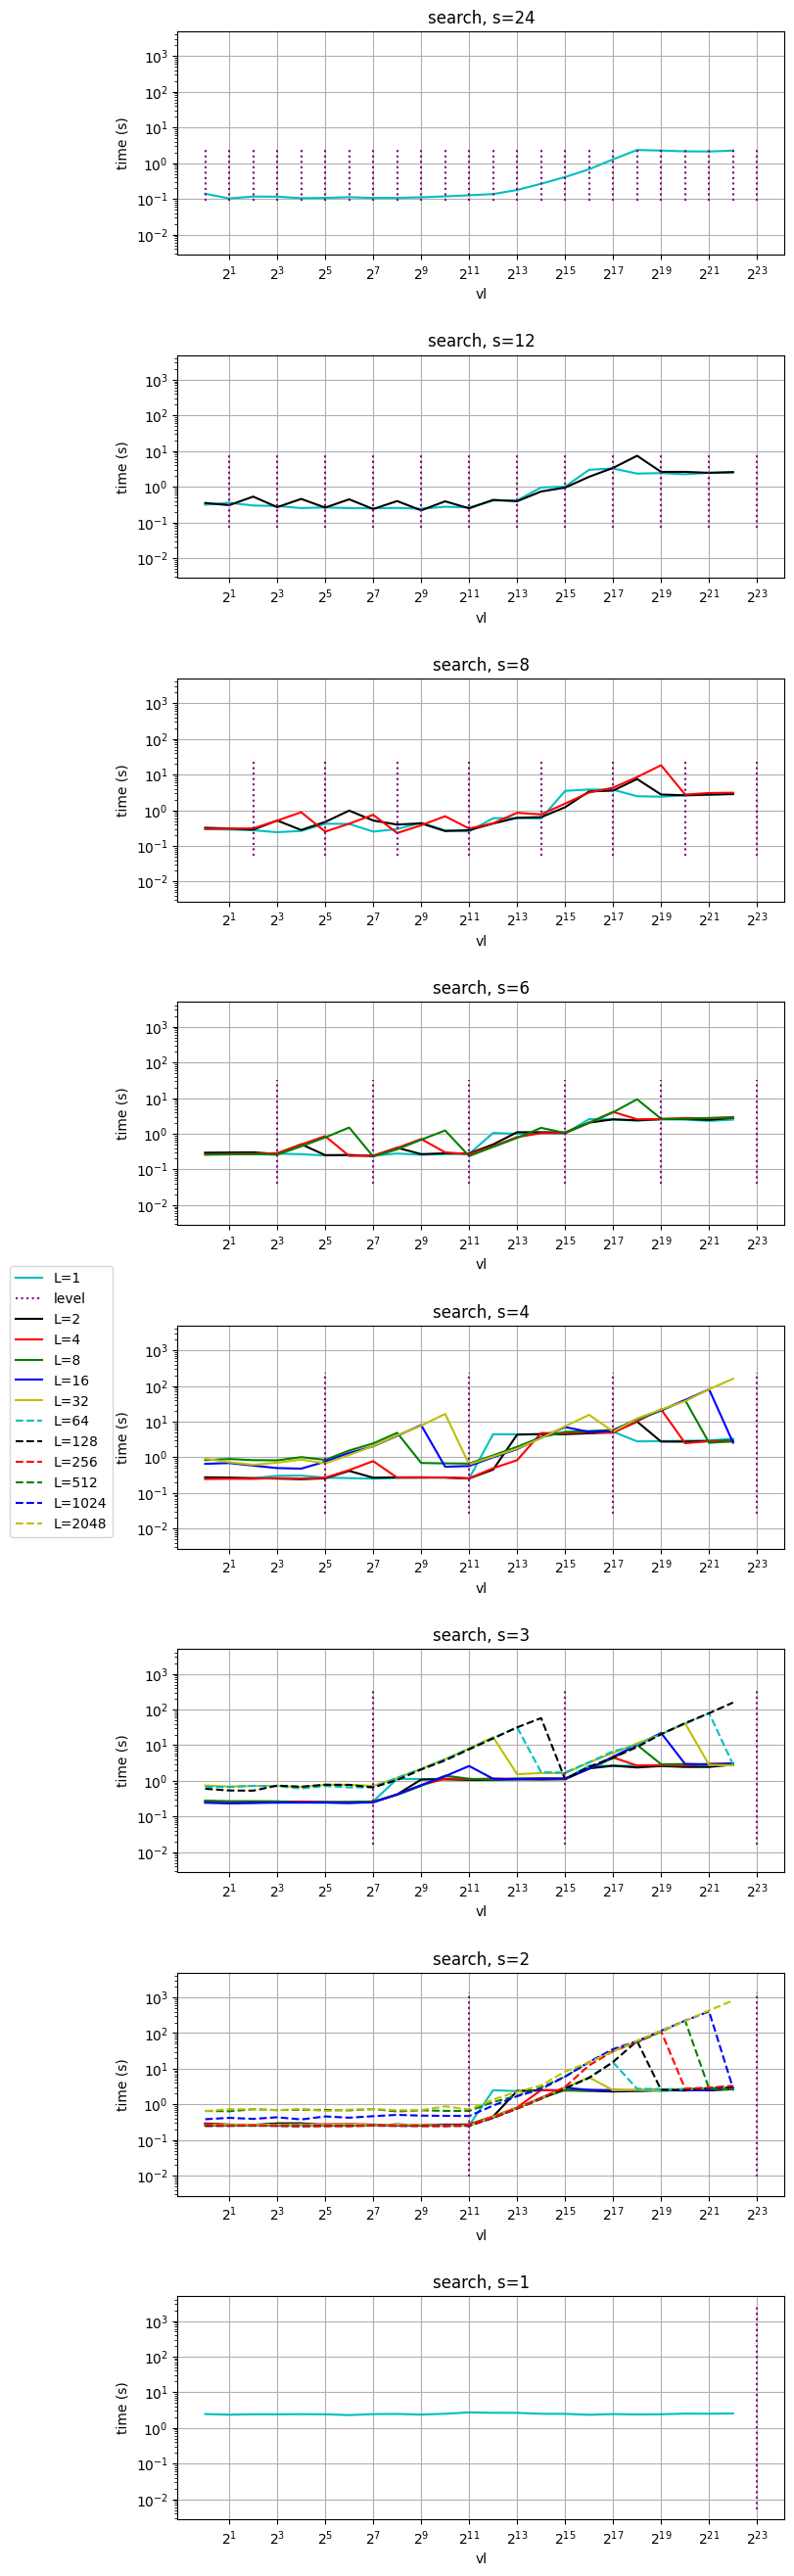

HDD (No Cache)


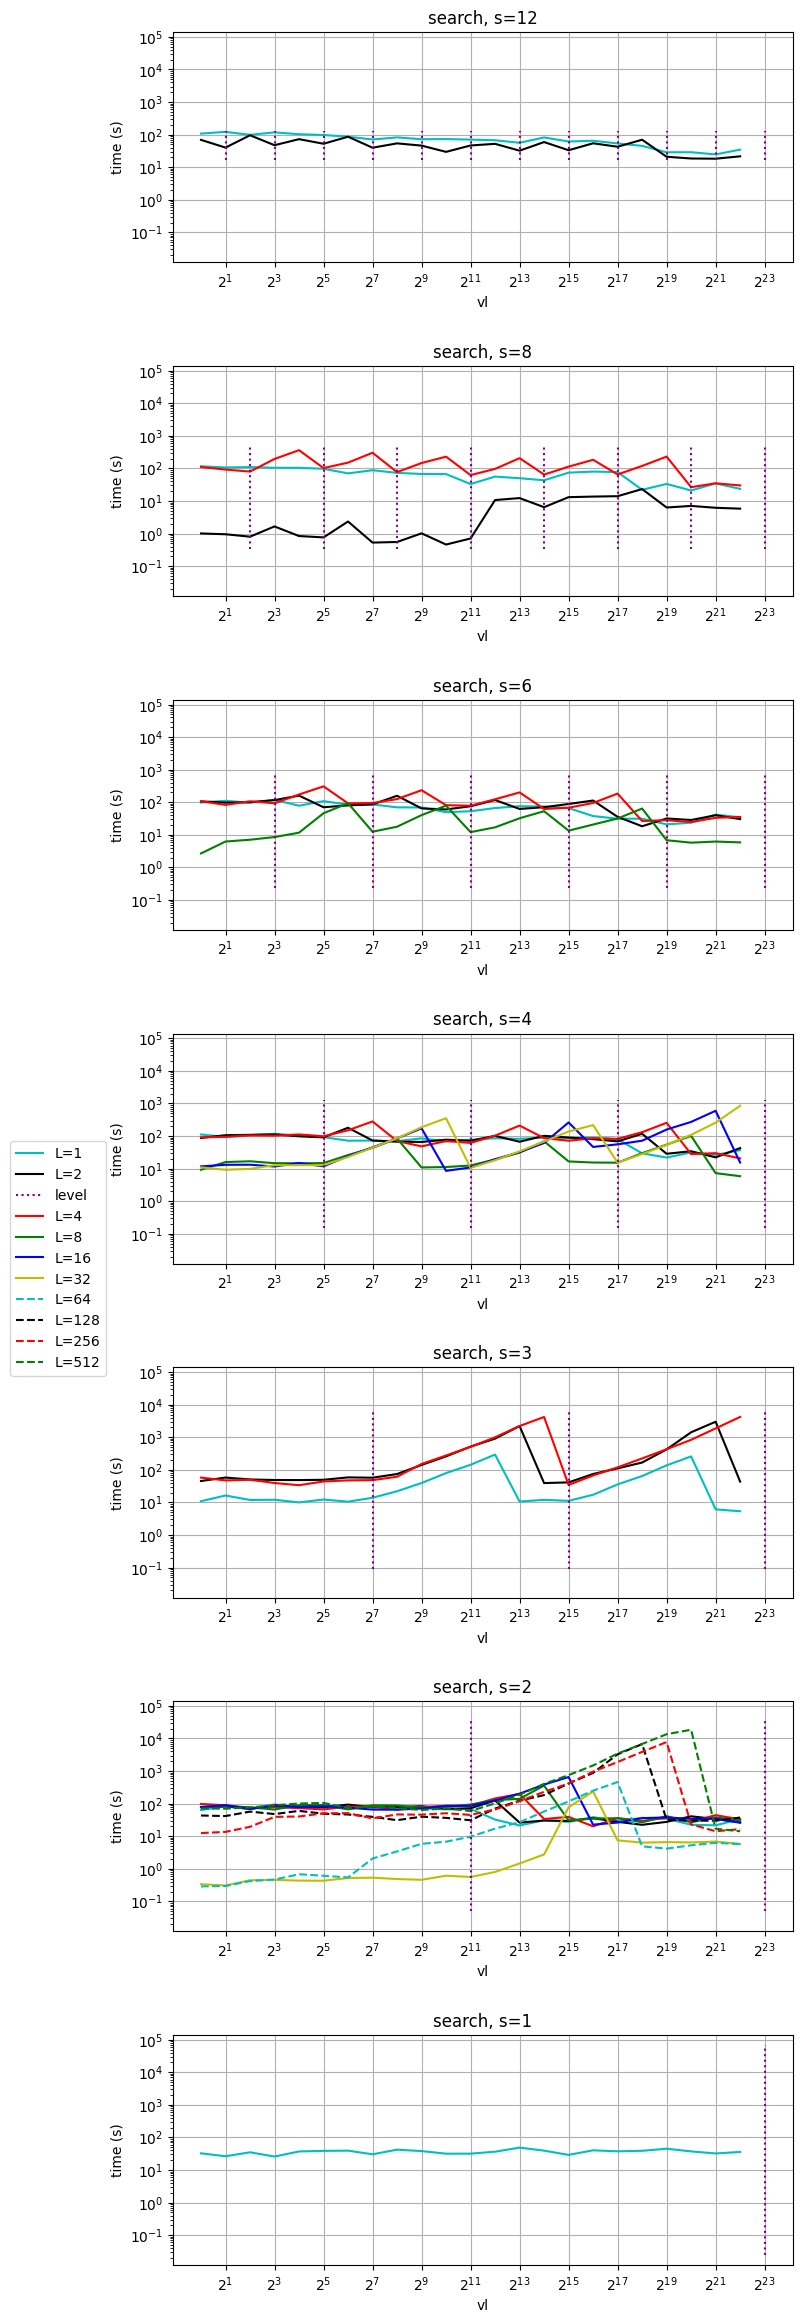

SSD (No Cache + Flush All)


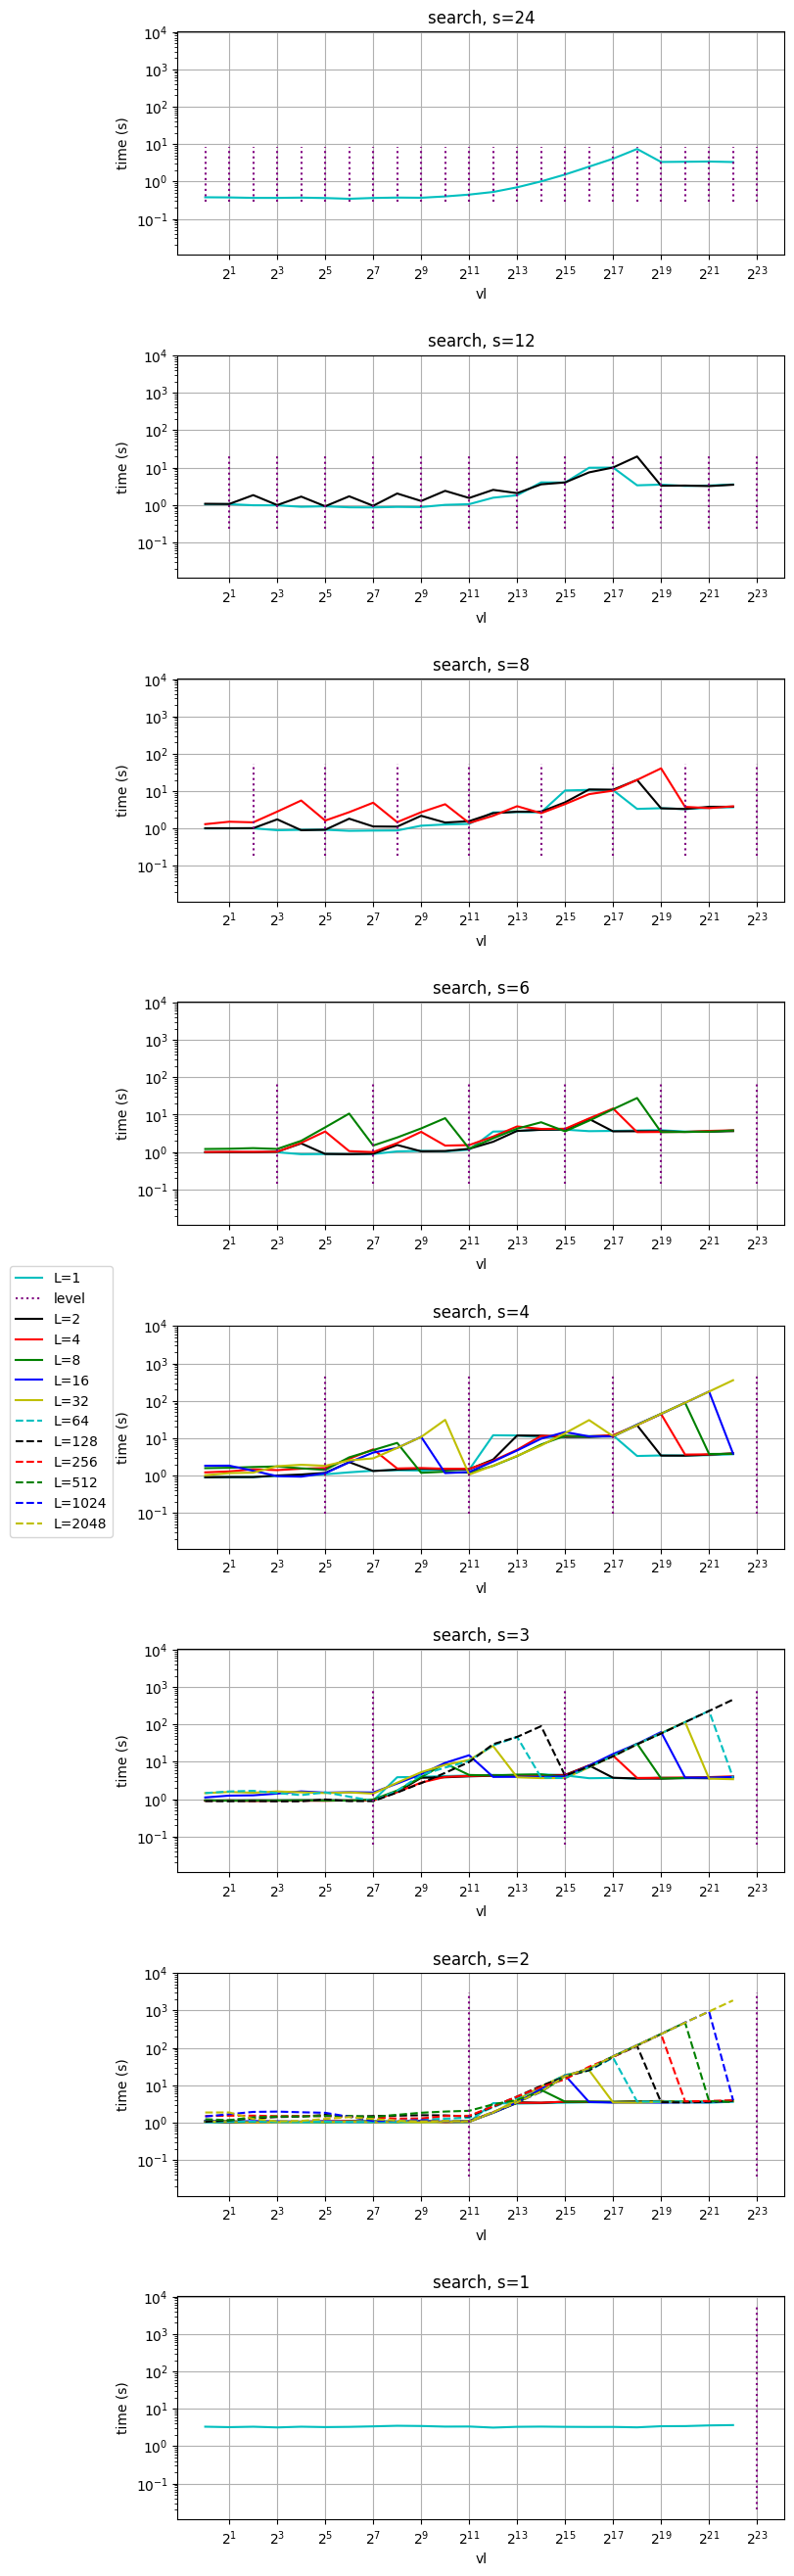

In [24]:
for group in groups:
    name, ofs, omap = group
    print(name)
    graph_by(ofs, 's', 'lf', 'vl', 'search', True, None)


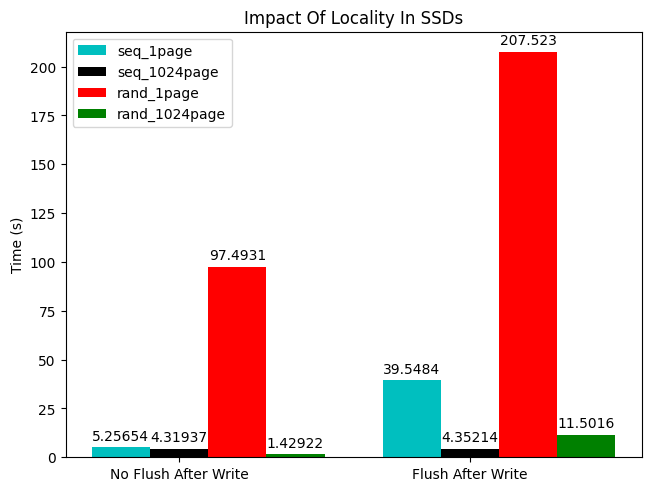

In [11]:
from io import StringIO
ssd_vs_loc_csv = '''cache,seq_1page,seq_1024page,rand_1page,rand_1024page
No Flush After Write,5.25654,4.31937,97.4931,1.42922
Flush After Write,39.5484,4.35214,207.523,11.5016'''
ssd_vs_loc = pd.read_csv(StringIO(ssd_vs_loc_csv))

# ssd_vs_loc.set_index('cache').plot.bar()
# plt.legend()
# plt.show()
# ssd_vs_loc.set_index('cache').T.plot.bar()
# plt.legend()
# plt.show()

grouped_bars(ssd_vs_loc, 'cache', 'Impact Of Locality In SSDs', 'Time (s)')
# t = ssd_vs_loc.set_index('cache').T.rename_axis('cache').rename_axis(None, axis=1).reset_index()
# grouped_bars(t, 'cache', 'Impact Of Locality In SSDs', 'Time (s)')
